<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/4_Feature_selection_%26_data_balancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter
from imblearn.combine import SMOTEENN, SMOTETomek

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [181]:
org = pd.read_csv('/content/gdrive/MyDrive/Datascience/Datasets/dataset_after_ops.csv')

df = org.copy()
df.dropna(inplace = True)
df["date"] = pd.to_datetime(df["date"])
df.insert(0,'new_date',pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S').astype(int))
df.drop(['date'], axis=1, inplace=True)

for col in df.columns:
  df[col] = pd.to_numeric(df[col],errors = 'coerce')
  df[col] =df[col].apply(lambda x: round(x, 3))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  


In [182]:
org

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate,Purity
0,2017-03-10 01:00:00,55.20,16.98,3163.452165,578.910104,398.770942,10.113760,1.729498,251.177960,250.208694,...,450.343243,446.972364,450.622040,449.948988,455.523590,464.487434,450.111873,66.91,1.31,1
1,2017-03-10 02:00:00,55.20,16.98,3133.256389,537.219661,399.871822,10.129742,1.667784,249.880589,250.214050,...,449.373361,450.249356,450.081222,450.328806,448.722983,455.501528,451.387700,67.06,1.11,1
2,2017-03-10 03:00:00,55.20,16.98,3479.482944,591.906744,398.763806,10.048403,1.732711,250.161328,250.104167,...,449.972878,450.868711,450.901822,451.145822,451.134189,459.981311,450.296722,66.97,1.27,1
3,2017-03-10 04:00:00,55.20,16.98,3228.036436,593.170106,399.866983,9.918614,1.731056,250.208772,250.204761,...,487.940706,491.462111,487.387206,494.528183,495.664011,502.763850,494.939889,66.75,1.36,1
4,2017-03-10 05:00:00,55.20,16.98,3327.280739,619.710806,399.615089,9.746029,1.765879,249.917800,250.160494,...,549.031539,549.983156,549.459572,549.975483,549.512533,560.696300,550.271772,66.63,1.34,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3417,2017-09-09 19:00:00,49.75,23.20,3221.735214,498.785884,384.302022,9.179293,1.660170,301.432594,299.781377,...,394.817435,497.870623,409.189681,400.281507,500.450507,400.089188,404.901971,65.05,1.65,1
3418,2017-09-09 20:00:00,49.75,23.20,4159.141084,510.780566,383.222063,9.394523,1.693840,300.181000,299.976217,...,402.231217,498.402434,392.437663,397.464723,497.219060,400.096337,400.453108,64.83,1.71,1
3419,2017-09-09 21:00:00,49.75,23.20,3010.053850,519.289535,384.117685,9.774855,1.735145,299.419465,300.058141,...,400.192648,500.891915,459.091225,401.133831,497.620930,404.153746,402.128718,64.29,1.80,1
3420,2017-09-09 22:00:00,49.75,23.20,3441.085839,493.451375,383.502232,9.779947,1.716522,299.738536,299.759214,...,397.905143,494.662857,830.694840,400.860500,516.438446,406.912643,396.059768,64.25,1.96,1


## **Approach 1**:  Feature selection -> data balacing

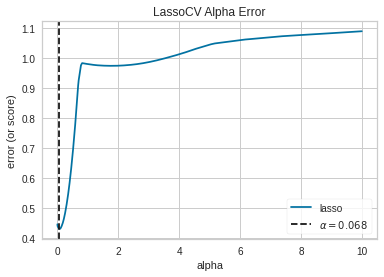

In [183]:
#https://www.scikit-yb.org/en/latest/api/regressor/alphas.html
import numpy as np

from sklearn.linear_model import LassoCV
from yellowbrick.regressor import AlphaSelection

X = df.drop(['% Silica Concentrate', 'Purity', 'new_date'], axis=1)
y = df['% Silica Concentrate']

# Create a list of alphas to cross-validate against
alphas = np.logspace(-10, 1, 1000)

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(X, y)
visualizer.show()

In [184]:
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

# Lasso (l1) penalty.
# The selectFromModel class from sklearn, which  will select the features which coefficients are non-zero
selector = SelectFromModel(linear_model.Lasso(alpha=0.068))
selector.fit(X, y)

selected_feat = X.columns[(selector.get_support())]

print('total features: {}'.format((X.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print(
    'features with coefficients greater than the mean coefficient: {}'.format(
        np.sum(
            np.abs(selector.estimator_.coef_) > np.abs(
                selector.estimator_.coef_).mean())))

total features: 22
selected features: 17
features with coefficients greater than the mean coefficient: 1


In [185]:
fs_db_lasso_df = df[selected_feat]
fs_db_lasso_df[['% Silica Concentrate', 'Purity', 'date']] = org[[ '% Silica Concentrate', 'Purity', 'date' ]]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [186]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

fs_db_lasso_df["date"] = pd.to_datetime(fs_db_lasso_df["date"])
fs_db_lasso_df.insert(0,'new_date',pd.to_datetime(fs_db_lasso_df['date'], format='%Y-%m-%d %H:%M:%S').astype(int))
fs_db_lasso_df.drop(['date'], axis=1, inplace=True)

X = fs_db_lasso_df.drop(['Purity'], axis=1)
y = fs_db_lasso_df['Purity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

print("Before: counts of label '1': {}".format(sum(y_train==1)))
print("Before: counts of label '0': {} \n".format(sum(y_train==0)))

smote_tl = SMOTETomek()
X_train_smote_tl_res, y_train_smote_tl_res = smote_tl.fit_resample(X_train, y_train.ravel())

print("After smote-tl: counts of label '1': {}".format(sum(y_train_smote_tl_res==1)))
print("After smote-tl: counts of label '0': {}".format(sum(y_train_smote_tl_res==0)))

X_train.insert(0,'dates',pd.to_datetime(X_train['new_date'], format='%Y-%m-%d %H:%M:%S'))
X_train.drop('new_date', axis=1, inplace=True)
X_train.insert(len(X_train.columns),'Purity',y_train)

X_train_smote_tl_res.insert(0,'dates',pd.to_datetime(X_train_smote_tl_res['new_date'], format='%Y-%m-%d %H:%M:%S'))
X_train_smote_tl_res.drop('new_date', axis=1, inplace=True)
X_train_smote_tl_res.insert(len(X_train_smote_tl_res.columns),'Purity',y_train_smote_tl_res)

fs_db_final = X_train.append(X_train_smote_tl_res, ignore_index=True)
fs_db_final = fs_db_final.sort_values(by="dates")

Before: counts of label '1': 1866
Before: counts of label '0': 529 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


After smote-tl: counts of label '1': 1622
After smote-tl: counts of label '0': 1622


## **Approach 2**: Data balacing -> Feature selection 

In [187]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


X = df.drop(['Purity'], axis=1)
y = df['Purity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

print("Before: counts of label '1': {}".format(sum(y_train==1)))
print("Before: counts of label '0': {} \n".format(sum(y_train==0)))

smote_tl = SMOTETomek()
X_train_smote_tl_res, y_train_smote_tl_res = smote_tl.fit_resample(X_train, y_train.ravel())

print("After smote-tl: counts of label '1': {}".format(sum(y_train_smote_tl_res==1)))
print("After smote-tl: counts of label '0': {}".format(sum(y_train_smote_tl_res==0)))
X_train_smote_tl_res.shape, y_train_smote_tl_res.shape, X_test.shape, y_test.shape

Before: counts of label '1': 1866
Before: counts of label '0': 529 

After smote-tl: counts of label '1': 1621
After smote-tl: counts of label '0': 1621


((3242, 24), (3242,), (1027, 24), (1027,))

In [188]:
X_train.insert(0,'dates',pd.to_datetime(X_train['new_date'], format='%Y-%m-%d %H:%M:%S'))
X_train.drop('new_date', axis=1, inplace=True)
X_train.insert(len(X_train.columns),'Purity',y_train)

X_train_smote_tl_res.insert(0,'dates',pd.to_datetime(X_train_smote_tl_res['new_date'], format='%Y-%m-%d %H:%M:%S'))
X_train_smote_tl_res.drop('new_date', axis=1, inplace=True)
X_train_smote_tl_res.insert(len(X_train_smote_tl_res.columns),'Purity',y_train_smote_tl_res)

smote_tl_db = X_train.append(X_train_smote_tl_res, ignore_index=True)
smote_tl_db = smote_tl_db.sort_values(by="dates")

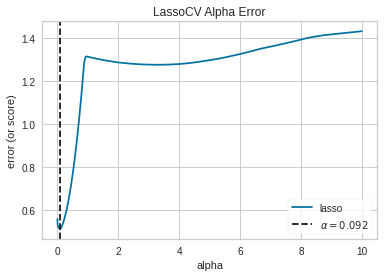

In [189]:
#https://www.scikit-yb.org/en/latest/api/regressor/alphas.html
import numpy as np

from sklearn.linear_model import LassoCV
from yellowbrick.regressor import AlphaSelection

X = smote_tl_db.drop(['% Silica Concentrate', 'Purity', 'dates'], axis=1)
y = smote_tl_db['% Silica Concentrate']

# Create a list of alphas to cross-validate against
alphas = np.logspace(-10, 1, 1000)

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(X, y)
visualizer.show()

In [190]:
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

# Lasso (l1) penalty.
# The selectFromModel class from sklearn, which  will select the features which coefficients are non-zero
selector = SelectFromModel(linear_model.Lasso(alpha=0.077))
selector.fit(X, y)

selected_feat = X.columns[(selector.get_support())]

print('total features: {}'.format((X.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print(
    'features with coefficients greater than the mean coefficient: {}'.format(
        np.sum(
            np.abs(selector.estimator_.coef_) > np.abs(
                selector.estimator_.coef_).mean())))

total features: 22
selected features: 15
features with coefficients greater than the mean coefficient: 1


In [191]:
db_fs_final = df[selected_feat]
db_fs_final[['% Silica Concentrate','Purity', 'dates']] = smote_tl_db[[ '% Silica Concentrate', 'Purity', 'dates' ]]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [192]:
all_dfs = [fs_db_final, db_fs_final]

Accuracy:  0 98.72340425531915
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       570
           1       0.99      0.99      0.99       840

    accuracy                           0.99      1410
   macro avg       0.99      0.99      0.99      1410
weighted avg       0.99      0.99      0.99      1410

ROC_AUC_SCORE  0.9976503759398496
_______________________________________________ 

Accuracy:  1 94.85981308411215
              precision    recall  f1-score   support

           0       0.96      0.82      0.89       208
           1       0.95      0.99      0.97       648

    accuracy                           0.95       856
   macro avg       0.95      0.91      0.93       856
weighted avg       0.95      0.95      0.95       856

ROC_AUC_SCORE  0.9913491215574549
_______________________________________________ 



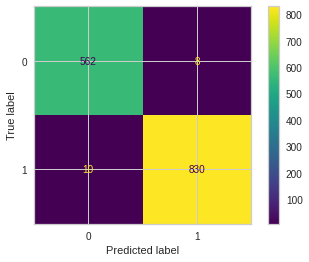

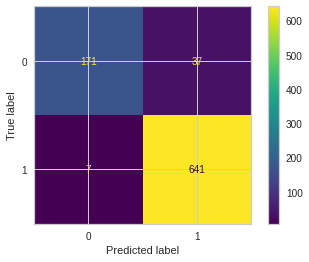

In [195]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#initialisation
model = 0
i = 0

for df in all_dfs:
  X = df.drop(['Purity', 'dates'], axis=1)
  y = df['Purity']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  mms = MinMaxScaler()
  X_train = mms.fit_transform(X_train)
  X_test = mms.transform(X_test)

  grid_params = {
      'n_neighbors' : [3,5,11,19], # Always odd numbers to avaid ties
      'weights': ['uniform', 'distance'],
      'metric': ['euclidean', 'manhattan']
  }

  grid = GridSearchCV(
      KNeighborsClassifier(),
      grid_params,
      cv = 5,
      n_jobs = -1 #use all resources
  )

  grid_results = grid.fit(X_train, y_train)
  best_params = [grid_results.best_params_['metric'],grid_results.best_params_['n_neighbors'],grid_results.best_params_['weights']]

  #KNN with the best params
  model = KNeighborsClassifier(n_neighbors=best_params[1], 
                            weights=best_params[2], 
                            metric=best_params[0], 
                            n_jobs=-1)
  model.fit(X_train, y_train)
  y_test_hat=model.predict(X_test) 
  test_accuracy=accuracy_score(y_test,y_test_hat)*100


  print('Accuracy: ',i,test_accuracy)
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);  
  y_pred = model.predict(X_test)

  print(classification_report(y_test,y_pred))

  y_pred_proba = model.predict_proba(X_test)[:,1]
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

  print('ROC_AUC_SCORE ',roc_auc_score(y_test,y_pred_proba))
  print('_______________________________________________ \n')
  i = i + 1

✅ Conclusion: Best approach is Feature selection then data balacing <br>
Accuracy: 98.72% <br>
ROC_AUC score: 0.997